# 뉴스 기사를 추상적 요약, 추출적 요약으로 요약해보기

## Step 0. 중요 모듈 import

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import urllib.request


[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj17/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1. 데이터 준비 및 확인
* 뉴스기사 데이터는 영어로 되어있고 기사의 요약된 정보가 담긴 'headlines' 항목과 기사의 원문 내용이 담긴 'text' 항목이 있다.

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## Step 2. 데이터 전처리 하기
---
### Step 2-1. 추출적 요약 데이터 분리
* 추출적 요약 때 사용할 데이터는 전처리가 되어있지 않아야 한다.
* 그래서 추출적 요약 때 사용할 데이터는 전처리 전에 data2라는 변수에 따로 저장해둔다.
* data2에는 98401개의 데이터가 들어가있다.

In [4]:
data = data[['text','headlines']]
data2 = data['text']
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,text,headlines
45575,The United States government on Friday said th...,Can't confirm reports of Nirav's presence in t...
40868,The woman shooter who opened fire at YouTube h...,YouTube shooter had accused YouTube of censori...
3017,India's new ambassador to China Vikram Misri t...,Vikram Misri takes charge as India's new envoy...
95744,Electronics maker Samsung's Vice Chairman Jay ...,Samsung Chief has not received any pay since h...
7370,Six US marines went missing after two military...,6 missing after 2 US military aircraft collide...
13238,A four-year-old girl died after being attacked...,4-yr-old girl dies after being attacked by str...
81509,A sweeper and a security guard have been arres...,3 arrested as video of couple romancing in mal...
81648,Reacting to actor Ranveer Singh's wax statue a...,"When you say Ranveer but think Shiamak Davar, ..."
55185,Responding to questions by the media about Ali...,"Alia is smarter than all of you combined, says..."
47390,The Supreme Court has sought Attorney General ...,"Can sitting MPs, MLAs practise law: SC asks At..."


In [113]:
len(data2)

98401

### Step 2-2. 중복 샘플 확인
* pd.nunique() 함수로 데이터의 중복 샘플 수를 확인한다.
* 'text'항목과 'headlines'항목의 숫자가 다른것을 보아 중복이 있다.

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


### Step 2-3. 중복 샘플 제거
* pd.drop_duplicates() 함수로 'text'항목 기준으로 중복 샘플을 제거한다.

In [6]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


### Step 2-4. null 값 확인
* pd.isnull() 함수로 빈 값 null 이있는지 확인한다.
* null 값이 없는것을 확인했다.

In [7]:
print(data.isnull().sum())

text         0
headlines    0
dtype: int64


### Step 2-5. 텍스트 정규화 
* 예를들어 can not = can't 이러한 같은 의미는 하나로 통일해 주어야 한다.

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


### Step 2-6. 불용어 확인
* 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재한다. 이를 불용어(stopwords)라고 불른다. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있다.

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

### Step 2-7. 텍스트 정규화  불용어 제거 함수

In [10]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

### Step 2-8. 텍스트 정규화  전처리 전, 후 결과 확인
* 결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고,과 같은 html 태그가 제거되었다. 또한 (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있다. 그리고 특수문자가 제거되면서 영어만 남았다.

In [11]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


### Step 2-9. 전체 텍스트 전처리
* 테스트를 해보았으니 전체 데이터를 전처리 해준다.

In [12]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

### Step 2-10. 전체 headlines 전처리

In [13]:
clean_headlines = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
data.isnull().sum()

text         0
headlines    0
dtype: int64

In [16]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


### Step 2-11. 샘플의 최대 길이 정하기
* padding 을위해 샘플의 길이의 분포를 확인했다.
* text와 headlines 의 길이분포를 보니 정규분포를 따르지 않았다.
* 일반적인 값들 보다 튀는 값들이 있기 때문이었다.
* headlines 데이터인 경우 5~13정도의 길이가 적당했다.
* text의 데이터인 경우 26~45정도의 길이가 적당했다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


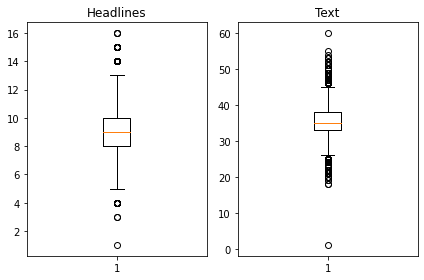

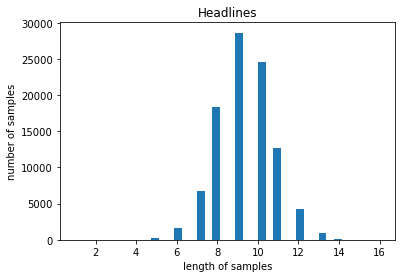

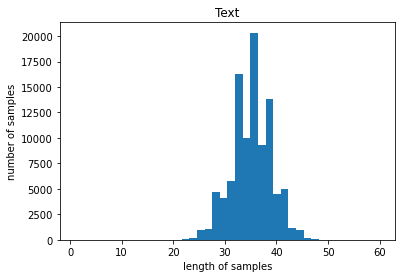

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### Step 2-12. 최대길이 제한할 경우 샘플 비율 확인

In [18]:
text_min_len = 26
text_max_len = 45

headlines_min_len = 5
headlines_max_len = 13

### Step 2-13. 정규분포를 따르지 않는 값들을 제외 할 경우 비율 확인

In [19]:
def below_threshold_len(max_len, min_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len or len(s.split()) >= min_len ):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이상 %s 이하인 샘플의 비율: %s'%(min_len, max_len,  (cnt / len(nested_list))))

In [20]:
below_threshold_len(text_min_len, text_max_len, data['text'])

전체 샘플 중 길이가 45 이상 26 이하인 샘플의 비율: 0.018716958113054086


In [21]:
below_threshold_len(headlines_min_len, headlines_max_len, data['headlines'])

전체 샘플 중 길이가 13 이상 5 이하인 샘플의 비율: 0.014426596177307849


### Step 2-14.정해진 길이보다 길면 제외

In [22]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 97863


In [23]:
data = data[data['text'].apply(lambda x: len(x.split()) >= text_min_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) >= headlines_min_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 97284


### Step 2-15. 정리 후 데이터 분포 확인
* 그래프가 정규 분포를 따르는 것을 볼 수 있다.

텍스트의 최소 길이 : 26
텍스트의 최대 길이 : 45
텍스트의 평균 길이 : 35.125765799103654
요약의 최소 길이 : 5
요약의 최대 길이 : 13
요약의 평균 길이 : 9.289842111755274


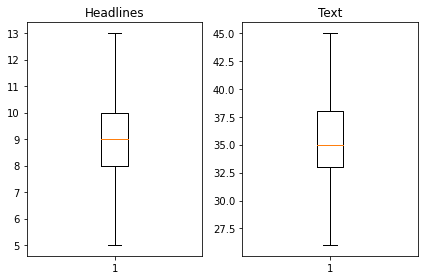

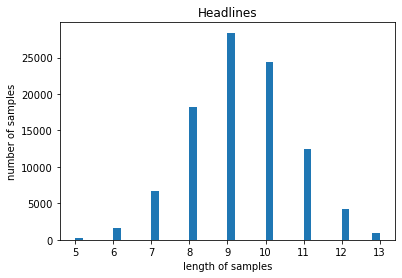

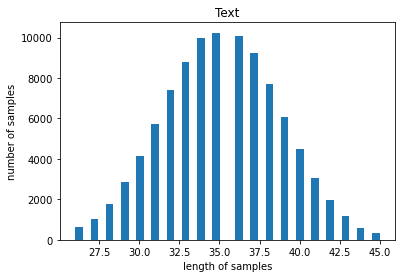

In [24]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### Step 2-16. 시작 종료 토큰 추가하기
* 문장의 시작과 끝을 알기 위해 시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 임의로 명명하고 앞, 뒤로 추가한다.

In [25]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,text,headlines,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


### Step 2-17. 다시 numpy 타입으로 저장

In [26]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### Step 2-18. 훈련셋 테스트셋 분리
* encoder_input과 크기와 형태가 같은 정수 시퀀스를 만들었다.

In [114]:
indices = np.arange(encoder_input.shape[0])
#np.random.shuffle(indices)
print(indices)

[    0     1     2 ... 97281 97282 97283]


### Step 2-19. 정수 시퀀스를 이용해 데이터 셈플 순서 정의

In [28]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [29]:
encoder_input[:10]

array(['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
       'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
       'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
       'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers op

### Step 2-20. 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

In [30]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19456


In [31]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 77828
훈련 레이블의 개수 : 77828
테스트 데이터의 개수 : 19456
테스트 레이블의 개수 : 19456


### Step 2-21. 단어 집합(vocaburary) 만들기 및 정수 인코딩 - text 데이터

In [32]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

* 빈도수가 낮은 단어들은 훈련 데이터에서 제외
* 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [33]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67818
등장 빈도가 6번 이하인 희귀 단어의 수: 46030
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21788
단어 집합에서 희귀 단어의 비율: 67.87283612020407
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4425824159746243


* 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기가 21788 이므로 src_vocab을 22000으로 정했다.

In [34]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

### Step 2-22. text 데이터 토크나이저로 정수형으로 변환
* texts_to_sequences()로 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행

In [35]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[6403, 6996, 8167, 9871, 8727, 1666, 1729, 1993, 1392, 623, 11666, 1730, 2324, 1278, 876, 22, 141, 1223, 1666, 8167, 2549, 610, 349, 963, 5038, 134, 3412, 2298, 1804, 1540, 2172, 8167, 209, 325, 1993, 2186, 62, 8446], [5570, 241, 1269, 1041, 537, 1430, 412, 20358, 597, 101, 2377, 223, 373, 342, 5467, 17, 2, 13606, 8598, 26, 20359, 3677, 2961, 2676, 20358, 4725, 101, 119, 17, 20358, 3524, 123, 2630, 537, 535, 100, 4562, 10332, 3693, 38, 14557, 21789, 11667, 2535], [25, 718, 822, 3, 695, 600, 269, 4641, 72, 223, 8, 88, 89, 88, 269, 142, 3, 265, 117, 88, 799, 237, 5370, 1291, 6714, 1311, 164, 410, 88, 1677, 3, 488, 2482, 2667, 322, 269, 115, 476]]


### Step 2-23. headlines 데이터 토크나이저로 정수형으로 변환

In [36]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [37]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29589
등장 빈도가 5번 이하인 희귀 단어의 수: 19319
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10270
단어 집합에서 희귀 단어의 비율: 65.29115549697522
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.600730310102623


* 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기가 10270 이므로 tar_vocab을 10000으로 정했다.

In [38]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4939, 8684, 8685, 3, 733, 4, 9401, 1886, 9, 1147, 1132], [1, 26, 3644, 161, 242, 368, 14, 2947, 5, 123, 39, 7], [1, 41, 1225, 336, 451, 559, 488, 8, 160, 624, 3017], [1, 8102, 188, 8103, 1743, 490, 944, 1724, 839, 369], [1, 47, 2223, 2892, 5, 100, 150, 82, 956, 182, 81, 10, 2668, 631]]
target
decoder  [[4939, 8684, 8685, 3, 733, 4, 9401, 1886, 9, 1147, 1132, 2], [26, 3644, 161, 242, 368, 14, 2947, 5, 123, 39, 7, 2], [41, 1225, 336, 451, 559, 488, 8, 160, 624, 3017, 2], [8102, 188, 8103, 1743, 490, 944, 1724, 839, 369, 2], [47, 2223, 2892, 5, 100, 150, 82, 956, 182, 81, 10, 2668, 631, 2]]


* 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장 후 삭제

In [39]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77828
훈련 레이블의 개수 : 77828
테스트 데이터의 개수 : 19456
테스트 레이블의 개수 : 19456


/home/aiffel-dj17/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Step 2-24. 패딩하기

In [40]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## Step 3. 모델 설계하기

In [41]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [42]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [43]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [44]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

### 어텐션 : 문장의 단어마다 포커스를 다르게 하여 해석.

In [45]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## Step 4. 모델 훈련하기
* early stopping으로 적절한 epoch에서 멈춘다.

In [46]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
305/305 [==============================] - 123s 404ms/step - loss: 5.2638 - val_loss: 4.7417
Epoch 2/50
305/305 [==============================] - 121s 396ms/step - loss: 4.7083 - val_loss: 4.4427
Epoch 3/50
305/305 [==============================] - 122s 399ms/step - loss: 4.3746 - val_loss: 4.2424
Epoch 4/50
305/305 [==============================] - 121s 396ms/step - loss: 4.1259 - val_loss: 4.1128
Epoch 5/50
305/305 [==============================] - 120s 394ms/step - loss: 3.9293 - val_loss: 3.9693
Epoch 6/50
305/305 [==============================] - 120s 395ms/step - loss: 3.7666 - val_loss: 3.8275
Epoch 7/50
305/305 [==============================] - 120s 395ms/step - loss: 3.6267 - val_loss: 3.7498
Epoch 8/50
305/305 [==============================] - 120s 394ms/step - loss: 3.5082 - val_loss: 3.6810
Epoch 9/50
305/305 [==============================] - 120s 394ms/step - loss: 3.4053 - val_loss: 3.6427
Epoch 10/50
305/305 [==============================] - 120s 394m

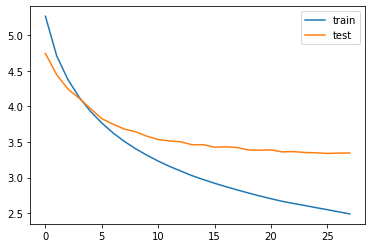

In [47]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Step 5. 인퍼런스 모델 구현하기
* 문자를 정수로 바꾸고 정수를 다시 문자로 바꾸는 과정이다.

In [48]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [49]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [50]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [51]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 6. 추상적 요약 모델 테스트
* 원문과 실제요약, 예측요약이 나오는 것을 확인할 수 있다.

In [52]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

* 트럼프 관련 기사를 확인해본다.
* 원문 : us president donald trump sunday slammed members party protecting sad republicans even carried line back little protect president trump tweeted comes republicans struggled come together bill repeal replace 
* 실제 요약 : trump slams for not protecting him 
* 예측 요약 :  trump slams trump for presidential violence

* 먼저 실제 요약과 예측 요약의 주어가 같아서 만족스럽다.
* 보기편하기 위해 구글번역을 돌려보았다.

### 구글번역 결과
* 원문 : 미국 대통령 도널드 트럼프 일요일은 회원 파티를 보호 슬픈 공화당 원을 보호 심지어 라인을 뒤로 운반 작은 보호 트럼프 트럼프 트위트가 온다 공화당 원이 힘겹게 모여 법안 폐지 교체
* 실제 요약 : 그를 보호하지 않는 트럼프 슬램
* 예측 요약 : 트럼프는 대통령 폭력에 대한 트럼프를 쾅쾅

* 구글 번역 결과 예측요약에서 쾅쾅이라는 단어가 왜 나왔는지 모르겠다. 그래도 실제 요약과 예측 요약이 얼추 비슷한 것 같다. 

In [53]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : us president donald trump sunday slammed members party protecting sad republicans even carried line back little protect president trump tweeted comes republicans struggled come together bill repeal replace 
실제 요약 : trump slams for not protecting him 
예측 요약 :  trump slams trump for presidential violence


원문 : govinda thanked rishi kapoor showing concern role jagga jasoos removed added good blood never speaks wrong said expected little professionalism director anurag basu want govinda work film ask first place rishi said 
실제 요약 : govinda thanks rishi for showing concern in row 
예측 요약 :  rishi is not rishi on rishi kapoor


원문 : hindi trailer kajol dhanush starrer film vip released sequel tamil film dhanush penned story also co producing sister law rajinikanth directing film scheduled release july 
실제 요약 : hindi trailer of kajol dhanush vip released 
예측 요약 :  trailer of rajkummar rao starrer released


원문 : official james bond twitter handle announced november release date new film 

예측 요약 :  us oil tanker to china sea amid china tensions


원문 : russian lawmakers urged president vladimir putin sanction poland bill ordering demolition soviet monuments legislation part poland de law states monuments cannot pay tribute persons organisations events symbolising systems notably lakh soviet soldiers died liberating poland nazis wwii 
실제 요약 : ask putin to sanction poland over anti law 
예측 요약 :  russia prez to vote for referendum


원문 : television personality kylie jenner snapchat hacked hacker posted message caption add kylie jenner followed post alleged hacker twitter account read got kylie however hour later supposed hacker wrote joke nude pictures kylie 
실제 요약 : hacker threatens to leak kylie jenner nude pictures 
예측 요약 :  kylie jenner instagram account gets trolled for kylie


원문 : supreme court tuesday directed sahara group chief roy deposit crore september also said process auctioning group aamby valley shall start next hearing case september supreme court ordered au

예측 요약 :  news of being used to pay for bail


원문 : india women team wicketkeeper sushma verma offered post deputy superintendent police himachal pradesh government cm virbhadra singh made announcement tuesday saying state proud achievement international cricket arena sushma hails shimla dismissals keeper women world cup 
실제 요약 : india women keeper sushma verma offered dsp post by hp govt 
예측 요약 :  india women hockey team mla to be minister


원문 : five year old baseball fan leo northern kentucky kicked boston red gordon got chance meet star sunday game leo mother amy later said leo loves baseball loves every single player thrilled first place 
실제 요약 : yr old baseball fan kicks star player ahead of match 
예측 요약 :  fan proposes to girlfriend during match celebration


원문 : britain year old adam peaty broke world record breaststroke set new one world championships tuesday peaty swam seconds seconds produced world championships notably peaty also britain gold metres breaststroke 
실제 요약 : se

## Step 7. 추출적 요약 해보기
* 전처리하지 않은 data2를 준비한다.

In [54]:
data2.head()

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
Name: text, dtype: object

* 패키지 Summa 에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습을 해볼 수 있다.

In [57]:
from summa.summarizer import summarize

In [120]:
print(data2[1])

Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


* summarize 함수에 data를 넣어본다.

In [116]:
summarize(data2[1], words=20)

'Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.'

### Step 7-1. 적절한 words 값 찾기
* for문으로 적절한 words값을 찾는다. 
* 13부터 요약문이 나오고 33부터는 너무많은 내용이 담긴 요약문이 나온다.
* 20정도의 값이 적당한 것 같다.

In [119]:
for i in range(1, len(data2[1].split()) ) :
    print('Summary:')
    print('i : ',i)
    print(summarize(data2[1], words=i))

Summary:
i :  1

Summary:
i :  2

Summary:
i :  3

Summary:
i :  4

Summary:
i :  5

Summary:
i :  6

Summary:
i :  7

Summary:
i :  8

Summary:
i :  9

Summary:
i :  10

Summary:
i :  11

Summary:
i :  12

Summary:
i :  13
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
Summary:
i :  14
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
Summary:
i :  15
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
Summary:
i :  16
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
Summary:
i :  17
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMySho

In [63]:
len(data2[1])

347

### Step 7-2. words=20일 때 다른 문장들도 잘 요약하는지 확인
* 잘 작동되었다.

In [85]:
for i in range(77828, 77900) :
    print('Summary:')
    print(summarize(data2[i], words=20))

Summary:
Alia Bhatt has said she will never look at herself as a star as that will completely change her attitude.
Summary:
Fatima Sana Shaikh and Sanya Malhotra, who starred as sisters Geeta and Babita Phogat in 'Dangal', can be seen singing and dancing to the song 'Chandu Ke Chacha' in a video shared by Sanya on Instagram.
Summary:
Actress Taapsee Pannu has said she was probably the quietest on the day Salman Khan came to shoot on sets of 'Judwaa 2'.
Summary:
'Nazm Nazm', a new song from the upcoming film 'Bareilly Ki Barfi' starring Kriti Sanon, Ayushmann Khurrana and Rajkummar Rao, has been released.
Summary:
Several 'Akhand Pathis' (Sikh priests) on Monday held a protest demanding an increase in their salaries at the Golden Temple complex in Amritsar, Punjab.
Summary:
A SoftBank spokesperson said that the company would "look forward" to results of Snapdeal's new independent plan.
Summary:
The emails were leaked days before the presidential election in May but the electoral commiss

* 15일 때는 작동하지 않았다.

In [81]:
print('Summary:')
print(summarize(data2[77829], words=15))

Summary:



In [80]:
len(data2)

98401

## Step 8. 추상적 요약 추출적 요약 비교해보기
* 추상적 요약은 전처리 과정에서 데이터가 많이 날라가서 추출적 요약 데이터와 인덱스가 다르다.
* 그래서 같은 text를 찾는 방법을 생각해냈다.
* 먼저 추상적 요약 결과에서 0번째 모델 결과를 확인한다.
* 핵심 단어가 lizard 라는 것을 확인했다.

In [69]:
decode_sequence(encoder_input_test[0].reshape(1, text_max_len))

' pregnant woman found in train bag in mumbai'

In [90]:
seq2text(encoder_input_test[0])

'lizard found veg biryani served passenger howrah delhi express train tuesday passenger ate biryani later discovered dead lizard tweeted complaint railway minister suresh prabhu incident comes amid cag report said food trains unfit human consumption '

### Step 8-1. 추상적 요약과 추출적 요약 같은 인덱스 찾기 

* 추상적 요약 데이터셋은 훈련셋과 테스트셋을 8:2로 분리했기 때문에 테스트셋 결과는 추출적요약의 data2에서는 70000번대 이상에 있다.
* 그래서 for 문과 if - in 문을 통해 'lizard'라는 단어를 검색해주었다.
* 검색해서 나온 인덱스에 해당하는 부분을 data2에서 출력하여 확인했다. 
* data2[78772]가 같은 것을 확인했다.
* A lizard was found in the veg biryani served to a passenger on the Howrah-Delhi Poorva Express Train on Tuesday. The passenger ate some of the biryani and later discovered the dead lizard, after which she tweeted her complaint to Railway Minister Suresh Prabhu. The incident comes amid CAG's report which said food on trains is "unfit for human consumption".

In [110]:
check_index=[]
for i in range(70000, 98400):
    if 'lizard' in data2[i] :
        print(i)
        check_index.append(i)
        
for j in check_index :
    print(data2[int(j)])
    print("\n")

75228
75476
78673
78772
82554
84619
85178
86314
88165
88750
89339
92000
93106
Turkish insurance company Tambov Turkey has been ordered to pay $26,300 (Ã¢ÂÂ¹16.8 lakh) after a lizard scared nearly 3,000 turkeys to death, according to reports. The lizard had strayed into the turkeys' holding area, causing panic and a stampede that led to their deaths by asphyxiation. Tambov Turkey manages nearly 7 lakh turkeys, which are insured against accidents and diseases.


E-commerce firms Snapdeal, IndiaMART, Wish and Buy, and Craft Comparison have been issued a notice for selling wildlife products on their platforms. The notices were served last week after their names surfaced during an investigation into an Indore-based company for selling prohibited wildlife products. The items being sold by online retailers reportedly included dried genitals of lizards.


The Ministry of Railways has cancelled a caterer's contract after a passenger found dead lizard in vegetable biryani served on Howrah-New D

### Step 8-2. 추상적 요약과 추출적 요약 비교 출력
* 추출적 요약은 전체 데이터 78772번째 이후부터 출력하니 잘 비교되도록 나오는 것을 확인할 수 있다.

In [121]:
for i in range(50, 60):
    origin_news = seq2text(encoder_input_test[i])
    print('전처리 전 원문 :', data2[78772+i])
    print("전처리 된 원문 :", origin_news)
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("추상적 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("추출적 요약 :", summarize(data2[78772+i], words=20))
    print("\n")

전처리 전 원문 : US President Donald Trump on Sunday slammed some members of his party for not protecting him. "It's very sad that Republicans, even some that were carried over the line on my back, do very little to protect their President," Trump tweeted. This comes after Republicans struggled to come together on a bill to repeal and replace Obamacare.
전처리 된 원문 : us president donald trump sunday slammed members party protecting sad republicans even carried line back little protect president trump tweeted comes republicans struggled come together bill repeal replace 
실제 요약 : trump slams for not protecting him 
추상적 요약 :  trump slams trump for presidential violence
추출적 요약 : "It's very sad that Republicans, even some that were carried over the line on my back, do very little to protect their President," Trump tweeted.


전처리 전 원문 : Govinda has thanked Rishi Kapoor for showing concern for him after his role in 'Jagga Jasoos' was removed. He added, "Good blood never speaks wrong", and further said

추상적 요약 :  govt to give bn to settle bill for bn deposits
추출적 요약 : The bill is equal to almost two centuries worth of the company's revenue.
The government alleged the company under-declared export revenues between 2000 and 2017.




### 비교
* 전처리 전 원문 : US President Donald Trump on Sunday slammed some members of his party for not protecting him. "It's very sad that Republicans, even some that were carried over the line on my back, do very little to protect their President," Trump tweeted. This comes after Republicans struggled to come together on a bill to repeal and replace Obamacare.
* 전처리 된 원문 : us president donald trump sunday slammed members party protecting sad republicans even carried line back little protect president trump tweeted comes republicans struggled come together bill repeal replace 
* 실제 요약 : trump slams for not protecting him 
* 추상적 요약 :  trump slams trump for presidential violence
* 추출적 요약 : "It's very sad that Republicans, even some that were carried over the line on my back, do very little to protect their President," Trump tweeted. 
---
### 구글번역 결과
* 전처리 전 원문 : 도널드 트럼프 미국 대통령은 일요일 자신을 보호하지 않는다는 이유로 당원 일부를 비난했습니다. 트럼프는 트위터에 "공화당 원들, 심지어 내 등을 짊어진 일부 사람들조차도 대통령을 보호하기 위해 거의하지 않는다는 사실이 매우 슬프다"고 트윗했다. 이것은 공화당 원들이 Obamacare를 폐지하고 대체하는 법안을 작성하기 위해 노력한 이후에 발생합니다.
* 전처리 된 원문 : 미국 대통령 도널드 트럼프 일요일은 회원 파티를 보호 슬픈 공화당 원을 보호 심지어 라인을 뒤로 운반 작은 보호 트럼프 트럼프 트위트가 온다 공화당 원이 힘겹게 모여 법안 폐지 교체
* 실제 요약 : 그를 보호하지 않는 트럼프 슬램
* 추상적 요약 : 트럼프는 대통령 폭력에 대한 트럼프를 쾅쾅
* 추출적 요약 : 트럼프는 트위터에 "공화당 원들, 심지어 내 등을 짊어진 일부 사람들조차도 대통령을 보호하기 위해 거의하지 않는다는 사실이 매우 슬프다"고 트윗했다.

# 마치며...
* 추상적 요약 내용이 특이하고 길이도 적절하고 주어도 같긴한데 그래도 아직 내용이 부족한 것  같다. 추출적 요약은 그래도 내용은 어느정도 맞지만 너무 길게 출력하는 것 같다. 
* 추상적 요약과 추출적요약을 비교하기위한 인덱스를 찾기 위해 rand.shuffle()을 사용하지 않았는데 딕셔너리 기능을 활용하면 random으로 섞어도 찾을 수 있는 방법이 있지 않을까 라는 생각이 들지만 내 머리속엔 아이디어가 떠오르지 않았다.
* 전처리과정이 길어서 전처리를 하면서 지치는 것 같다.